In [136]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.style.use('ggplot')
plt.rc('font', size=15)
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True) # 온라인이 아닌 상황에서 처리를 위한 명시 코드

from tqdm import tqdm_notebook

from eunjeon import Mecab

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
gensim.__version__  # '3.8.3'

from sklearn.decomposition import PCA

In [137]:
import preprocess_kr

In [138]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.options.display.float_format = '{:.2f}'.format

In [139]:
import warnings
warnings.filterwarnings('ignore')

In [140]:
# 전처리된 정제된 파일을 사용한다.
df = pd.read_table('./data/kr_전지적 독자 시점_episode_total_cleaned_list.txt', header =None)

In [141]:
df.columns = ['Review']
df.head()

,Review
0,전설이 시작된다
1,전독시 소설은 안봤는데 이거 재밌움 웨툰은 일단 존잼
2,나는유중혁이다
3,소설은 완결났길래 이것도 완결 가까워지면 몰아보려고 하는데 지금 전개가 소설 몇화쯤인가요
4,정주행가는중


# mecab 토큰화 및 불용어 제거

In [142]:
def get_tokenized_data(df):
    """
    mecab 형태소 분석기를 이용하여 토큰화 및 불용어 제거하는 함수¶
    """
    
    # 불용어 생성
    stopwords = preprocess_kr.make_stop_words()

    # mecab 형태소 분석기 객체 생성 
    mecab = Mecab('C:/mecab/mecab-ko-dic')

    # 결과 리스트
    tokenized_data = []

    # 원래 진행하고자했던 반복문 for i in range(100)에서 'in' 뒤에 문장을 tqdm()으로 감싸주면 진행 상황이 bar로 표현된다.
    # tqdm_notebook 은 tqdm 의 Jupiter Notebook version, progress bar가 예쁘다.
    for sentence in tqdm_notebook(df['Review']):
        tokenized_sentence = mecab.morphs(sentence) # mecab 문장 토큰화

        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거    
        stopwords_removed_sentence = [word for word in stopwords_removed_sentence if len(word) > 1] # 한글자 제거

        tokenized_data.append(stopwords_removed_sentence)
        
    return tokenized_data

def show_review_info(tokenized_data):
    """
    리뷰 길이 분포 확인 함수
    """
    print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
    print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
    plt.hist([len(review) for review in tokenized_data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

# Word2Vec으로 토큰화된 tokenized_data를 학습

In [143]:
def get_model_wv(tokenized_data):
    """
    토큰화된 데이터를 Word2Vec 알고리즘을 학습시켜 모델을 반환하는 함수
    """
    # Word2Vec으로 토큰화된 tokenized_data를 학습
    from gensim.models import Word2Vec
    # gensim 4.2 vector_size
    # gensim 3.8.3 size
    model = Word2Vec(sentences = tokenized_data, size = 200, window = 5, min_count = 50, workers = 4, sg = 1)
    
    # embedding_model = Word2Vec(tokenized_contents, size=100, window = 2, min_count=50, workers=4, iter=100, sg=1)
    
    # 포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 
    # 주변 단어(window)는 앞뒤로 두개까지 보되, 
    # 코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외해라. 
    # CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 
    # 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
    
    # Word2Vec 임베딩 행렬의 크기를 확인
    print("model.wv.vectors.shape: ",model.wv.vectors.shape)
    
    return model    

def print_most_similar_words(model, words_list): 
    """
    특정단어 리스트를 입력받아 유사도를 출력하는 함수
    """
    similar_words = []
    for keyword in words_list:        
        items = model.wv.most_similar(keyword)
        print('[', keyword, '] 와 관련있는 단어들 :' , items)
        print()
        similar_words.append(items)
    return similar_words
        
def get_similarity_btw_two_words(model, w1,w2):
    """
    단어간 유사도 확인 함수
    """
    
    # 모델로부터 단어벡터를 구한다.
    word_vectors = model.wv
    
    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]
    
#     print(vocabs)

    # 단어간 유사도를 반환
    return word_vectors.similarity(w1, w2)
        
def get_similarity_df(keyword):
    """
    특정 키워드를 입력받아 관련있는 단어를 찾고 유사도를 구하는 함수
    """
    similar_word = model.wv.most_similar(keyword)
    similar_word_df = pd.DataFrame(similar_word)
    similar_word_df.columns=["유사단어","유사도"]
    similar_word_df
    return similar_word_df   

def plot_2d_graph(vocabs, xs, ys):
    """
    단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그리는 함수
    """
    plt.figure(figsize=(10,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))    
        
def reduce_dimension_PCA(word_vectors_list):
    """
    PCA를 이용하여 차원을 축소하는 함수
    """
    pca = PCA(n_components=2)
    xys = pca.fit_transform(word_vectors_list[:10])
    xs = xys[:,0]
    ys = xys[:,1]
    return xs, ys        

# 1. 토큰화

In [144]:
tokenized_data = get_tokenized_data(df)
tokenized_data[:10]

stop_words made


  0%|          | 0/276161 [00:00<?, ?it/s]

[['전설', '시작'],
 ['전독시', '소설'],
 ['유중혁'],
 ['소설', '완결', '완결', '가까워', '전개', '소설'],
 ['정주', '행가'],
 ['전독시', '웹툰', '소설', '그림', '별론데', '그림', '체고', '독시', '만들', '함하', '사랑'],
 ['작가', '결말'],
 ['전독시',
  '당하',
  '댓글',
  '들어온',
  '화면',
  '확인',
  '수가',
  '답글',
  '제외',
  '답글',
  '유독',
  '답글',
  '보인다면',
  '내용',
  '차단',
  '도록',
  '개꿀',
  '기억',
  '기분',
  '망치',
  '전체',
  '댓글',
  '구분',
  '으므로',
  '장합'],
 ['김독자', '못생긴', '설정'],
 ['주행', '시작']]

# 2. 댓글 정보 확인

리뷰의 최대 길이 : 250
리뷰의 평균 길이 : 4.287940730226208


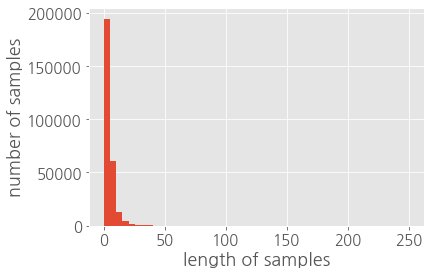

In [149]:
show_review_info(tokenized_data)

# 3. tokenized_data로 모델을 학습

In [150]:
model = get_model_wv(tokenized_data)

model.wv.vectors.shape:  (3057, 200)


In [151]:
# 모델을 저장한다.
model.save('./data/word2vec_kr.model')
 
# 저장한 모델을 읽어온다.
model = Word2Vec.load('./data/word2vec_kr.model')

# 4. 유사단어 검색

In [152]:
#words_list = ['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']

"""
['소설' '26712'],
        ['작가' '13993']
        ['주인공' '5112']
        ['원작' '4246']
        ['연출' '3021']
        ['작화' '2891']
        ['스토리' '1886']
        ['묘사' '1413']
        ['퀄리티' '1233']
        ['캐릭터' '1077']

"""

words_list = ['소설', '작가', '주인공', '원작', '연출', '작화', '스토리', '묘사', '퀄리티', '캐릭터']
topics = print_most_similar_words(model, words_list)

[ 소설 ] 와 관련있는 단어들 : [('감회', 0.7110480070114136), ('행중', 0.7091745138168335), ('원작', 0.7020782828330994), ('새롭', 0.674897313117981), ('정주', 0.6740650534629822), ('정독', 0.6715449094772339), ('달렸', 0.6641919612884521), ('화수', 0.6634138226509094), ('실감', 0.6590080261230469), ('텍스트', 0.6450512409210205)]

[ 작가 ] 와 관련있는 단어들 : [('택배', 0.5783209204673767), ('숑님', 0.5672290921211243), ('만수무강', 0.5457068085670471), ('오래오래', 0.5422040224075317), ('십쇼', 0.5249909162521362), ('꾸준히', 0.5241444110870361), ('연제', 0.5161762237548828), ('계신', 0.5092076659202576), ('예술', 0.5063756704330444), ('줄어들', 0.49940070509910583)]

[ 주인공 ] 와 관련있는 단어들 : [('악당', 0.6356245279312134), ('버프', 0.5775392055511475), ('사이코패스', 0.5659276247024536), ('아군', 0.5564793944358826), ('위기', 0.5461502075195312), ('패스', 0.5444369912147522), ('구마', 0.5406832695007324), ('악역', 0.5384438037872314), ('트롤', 0.5362353324890137), ('조연', 0.5260715484619141)]

[ 원작 ] 와 관련있는 단어들 : [('소설', 0.7020782828330994), ('화수', 0.5980125665664673), ('아쉬운'

In [153]:
topic_list = []
for topic in words_list:
    topic_list.append(topic)
    topic_list.append(topic)
topic_list

['소설',
 '소설',
 '작가',
 '작가',
 '주인공',
 '주인공',
 '원작',
 '원작',
 '연출',
 '연출',
 '작화',
 '작화',
 '스토리',
 '스토리',
 '묘사',
 '묘사',
 '퀄리티',
 '퀄리티',
 '캐릭터',
 '캐릭터']

In [154]:
df = pd.DataFrame(data=[], 
                  index = ['0','1','2','3','4','5','6','7','8','9'],
                  columns=[ topic_list,  ['topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity']])  

for index,topic in enumerate(topics): 
    for idx, tup in enumerate(topic):
        word, similarity = tup
        topic_name = words_list[index]
        df[topic_name,'topic'][idx] = word
        df[topic_name,'similarity'][idx] = similarity
df

소설               작가               주인공               원작               연출  \
  topic similarity topic similarity  topic similarity topic similarity topic   
0    감회       0.71    택배       0.58     악당       0.64    소설       0.70   연출력   
1    행중       0.71    숑님       0.57     버프       0.58    화수       0.60   이펙트   
2    원작       0.70  만수무강       0.55  사이코패스       0.57   아쉬운       0.59    천칭   
3    새롭       0.67  오래오래       0.54     아군       0.56  어마어마       0.59    쳣다   
4    정주       0.67    십쇼       0.52     위기       0.55    각색       0.58    수왕   
5    정독       0.67   꾸준히       0.52     패스       0.54    에바       0.58    호명   
6    달렸       0.66    연제       0.52     구마       0.54    기반       0.58    함대   
7    화수       0.66    계신       0.51     악역       0.54    구성       0.57    지린   
8    실감       0.66    예술       0.51     트롤       0.54   따라가       0.57   감수성   
9   텍스트       0.65   줄어들       0.50     조연       0.53    실감       0.57    재현   

                작화              스토리               묘사              퀄리티  \
  similarity topic similarity topic similarity topic similarity topic   
0       0.80   퀄리티       0.77    구성       0.75    표현       0.66    퀄이   
1       0.77    그림       0.75    참신       0.70    서술       0.62    투신   
2       0.75   연출력       0.75    깔끔       0.68   감정선       0.60    작화   
3       0.73    투신       0.73    방대       0.68    반영       0.60   연출력   
4       0.72    퀄이       0.70   흘러가       0.68    놀랍       0.59    체도   
5       0.72    체도       0.70    흥미       0.68    보일       0.58    채색   
6       0.71    쳣다       0.68    지루       0.67    구현       0.58    분량   
7       0.71    채색       0.67  어마어마       0.67    실감       0.57    손목   
8       0.71    액션       0.67    유치       0.67   디테일       0.57    작이   
9       0.70    구성       0.66    에바       0.66    입술       0.57    고퀄   

               캐릭터             
  similarity topic similarity  
0       0.85    캐릭       0.75  
1       0.82    매력       0.71  
2       0.77    주연       0.69  
3       0.77    조연       0.64  
4       0.76  엑스트라       0.63  
5       0.74    악역       0.62  
6       0.73    감성       0.62  
7       0.72    특이       0.61  
8       0.72    러브       0.60  
9       0.72   디자인       0.60

In [155]:
df_topic1 = df['스토리','topic']
#df_topic1.columns = ['Name']
df_topic1 = df_topic1.to_frame()
df_topic1.columns = ['Item']
df_topic1['Topic'] = '스토리'
df_topic1['similarity'] = df['스토리','similarity']
#df_topic1 = df_topic1.set_index('Topic')
df_topic1

,Item,Topic,similarity
0,구성,스토리,0.75
1,참신,스토리,0.70
2,깔끔,스토리,0.68
3,방대,스토리,0.68
4,흘러가,스토리,0.68
5,흥미,스토리,0.68
6,지루,스토리,0.67
7,어마어마,스토리,0.67
8,유치,스토리,0.67
9,에바,스토리,0.66


In [156]:
df_topic1['Item'].values

array(['구성', '참신', '깔끔', '방대', '흘러가', '흥미', '지루', '어마어마', '유치', '에바'], dtype=object)

# 네트워크 차트

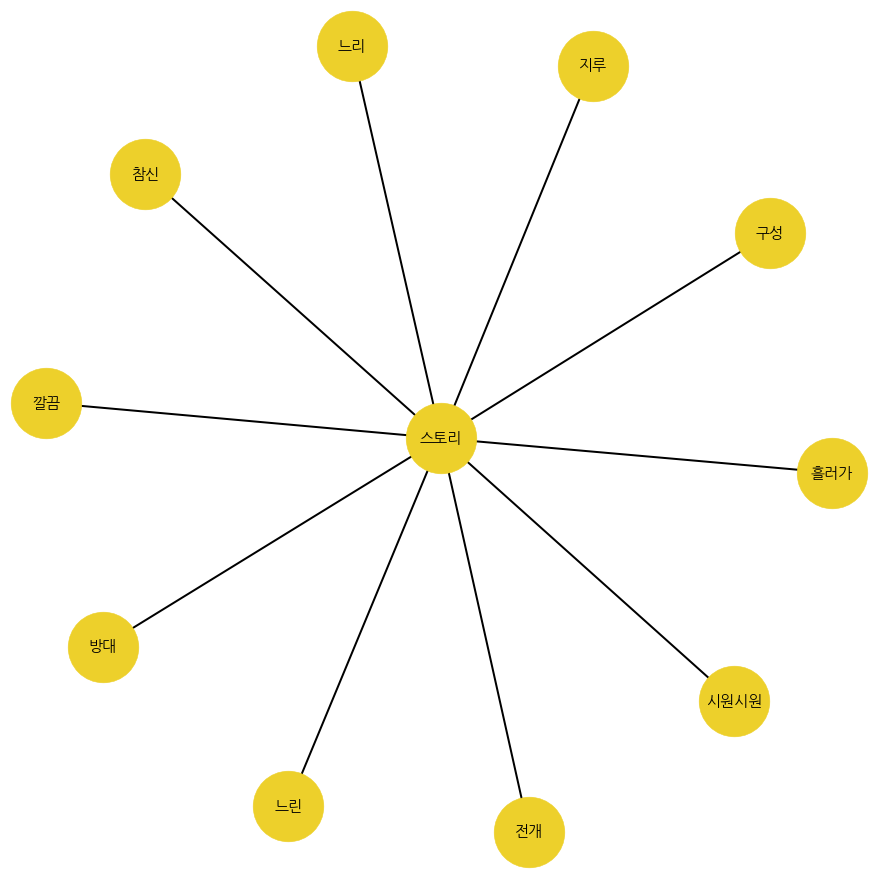

In [97]:
# !pip install decorator==5.0.9
# !pip install networkx==2.6.1 
"""
decorator와 networkx 모듈 사이의 종속성 때문에 발생하는 문제이다.

- decorator 모듈을 5.0.9 이상으로 재설치해주고

- networkx 도 2.6.1 이상으로 재설치해준 후

- 커널을 껐다 키면 문제가 해결된다.  

https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
"""

import networkx as nx
import numpy as np

                
g = nx.Graph()
g = nx.from_pandas_edgelist(df_topic1, source='Item',target='Topic')

# nx.circular_layout(g)

plt.figure(figsize = (12, 12))
# nx. draw_networkx
nx.draw(g,  with_labels = True, node_color = '#edd02b', 
                 width = 2.0,
                 node_size = 5000, font_size = 15, font_family ='NanumGothic')
plt.show()    


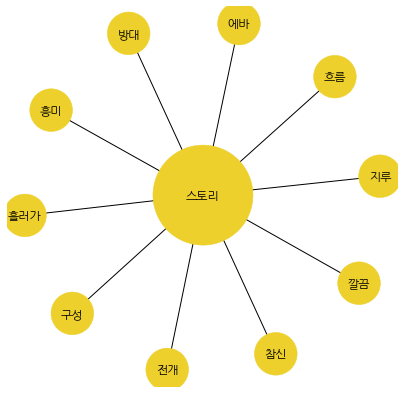

In [47]:
G_symmetric = nx.Graph()
G_symmetric = nx.from_pandas_edgelist(df_topic1, source='Item',target='Topic')
# print(nx.info(G_symmetric))

pos = nx.spring_layout(G_symmetric)
betCent = nx.betweenness_centrality(G_symmetric, normalized=True, endpoints=True)


node_color = [20000.0 * G_symmetric.degree(v) for v in G_symmetric]
node_size =  [v * 10000 for v in betCent.values()]

pr = nx.pagerank(g)
# print(nsize)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize -min(nsize)/ (max(nsize) - min(nsize)))


plt.figure(figsize=(7,7))
nx.draw_networkx(G_symmetric, pos=pos, with_labels=True,
#                  node_color=node_color,
                 node_size=node_size,
                 node_color = '#edd02b',
                 font_family ='NanumGothic')
plt.axis('off');

In [49]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import pandas as pd
df = pd.DataFrame({
    'Name': ['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리'],
    'Value': [65,65,65,65,65,65,65,65,65,65]
    
})
df


,Name,Value
0,독자,65
1,소설,65
2,작가,65
3,그림,65
4,연출,65
5,주인공,65
6,캐릭터,65
7,원작,65
8,작화,65
9,스토리,65


In [51]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import pandas as pd
df = df_topic1

circles = circlify.circlify(
    df['Value'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(10,10))

# Title
ax.set_title('Basic circular packing')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = df['Items']

# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2,color='#ffc4c4'))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center',
          size=24
     )

NameError: name 'circlify' is not defined

#  5. 단어간 유사도 확인(등장인물간 유사도 측정)

In [56]:
get_similarity_btw_two_words(model, '김독자','웹툰')

0.116826855

In [57]:
get_similarity_btw_two_words(model, '독자','웹툰')

0.17506583

In [67]:
get_similarity_btw_two_words(model, '독자','수영')

0.3075714

In [66]:
get_similarity_btw_two_words(model, '김독자','유중혁')

0.46758166

# 6. 유사단어와 유사도를 데이터프레임으로 확인

In [229]:
words_list

['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']

In [158]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import plotly
import cufflinks as cf
import pandas as pd
import numpy as np

words_list = ['소설', '작가', '주인공', '원작', '연출', '작화', '스토리', '묘사', '퀄리티', '캐릭터']

for word in words_list:
    
    similar_word_df = get_similarity_df(word)
    fig = similar_word_df.iplot(kind='pie',labels = "유사단어", 
                                    values="유사도", textinfo="percent+label",
                                    title= word + ' 관련 단어 Top10', hole = 0.3, asFigure=True)
    filename = './data/'+ word + '.html'   
    plotly.offline.plot(fig,filename=filename)
    fig.update_layout(font_size=17)
    fig.show()

# Text 클래스¶
- NLTK의 Text 클래스는 문서 분석에 유용한 여러가지 메서드를 제공한다. 토큰열을 입력하여 생성한다.

In [159]:
from nltk import Text

# from nltk.tokenize import RegexpTokenizer
# retokenize = RegexpTokenizer("[\w]+")

# text = Text(retokenize.tokenize(tokenized_data))

# 데이터 정제
cleaned_doc = preprocess_kr.preprocess()
word_tokens = preprocess_kr.generate_word_tokens(cleaned_doc)
stop_words = preprocess_kr.make_stop_words()
vocab = preprocess_kr.remove_stop_words(word_tokens, stop_words)
print("Document cleaned.")
vocab[:10]

Preprocess Done.
word_tokens generated.
stop_words made
stop_words removed
Document cleaned.


TypeError: unhashable type: 'slice'

# 7. PCA 차원 축소 및 유사도 시각화(동작 안 함)

In [ ]:
# xs, ys = reduce_dimension_PCA(word_vectors_list)
# plot_2d_graph(vocabs, xs, ys)